# Lab 0 - Pytorch Recap

In this laboratory, you will review the main objects that you will need in this course related to PyTorch, the deep learning framework used to develop and train neural networks in Python.

This notebook is heavily based on the tutorials of the [secml-torch library](https://github.com/pralab/secml-torch), [you can find the original here](https://github.com/pralab/secml-torch/blob/main/docs/tutorials/01-introduction.ipynb).

## Setup 
We need to setup the environment for this (and the following laboratories).

We will use **virtual environments**, which define a re-usable environment for the laboratories, by specifying the exact software dependancies and their versions.

First, install the [Python](https://marketplace.visualstudio.com/items?itemName=ms-python.python) and [Jupyter Notebook](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) extensions for your Visual Studio code application.


Then, clone this repository in your current folder:

```bash
git clone git@github.com:zangobot/teaching_material.git
cd teaching_material
```

Once inside the folder, create and activate a virtual environment:
```bash
python -m venv tai_env
source tai_env/bin/activate
```

Now you can activate the environment in Visual Studio code (by clicking on the **Select Kernel** button).
This will restart the runtime. Once you did this, you can continue below.



In [150]:
try:
    import secmlt
    import sklearn
    import matplotlib
except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch
    %pip install scikit-learn
    %pip install matplotlib


In [151]:
import torch
print("Pytorch version:", torch.__version__)

import secmlt
print("secml-torch version:", secmlt.__version__)

Pytorch version: 2.8.0
secml-torch version: 1.3



You should have Pytorch > 2 and secml-torch >= 1.3 installed inside your environment.


## Data creation

We now recap the main Pytorch functionalities, by creating some synthetic data, a model, training it and testing it.
[You can find a complete set of tutorials here.](https://docs.pytorch.org/tutorials/)

We first create some data using another library called `scikit-learn`.

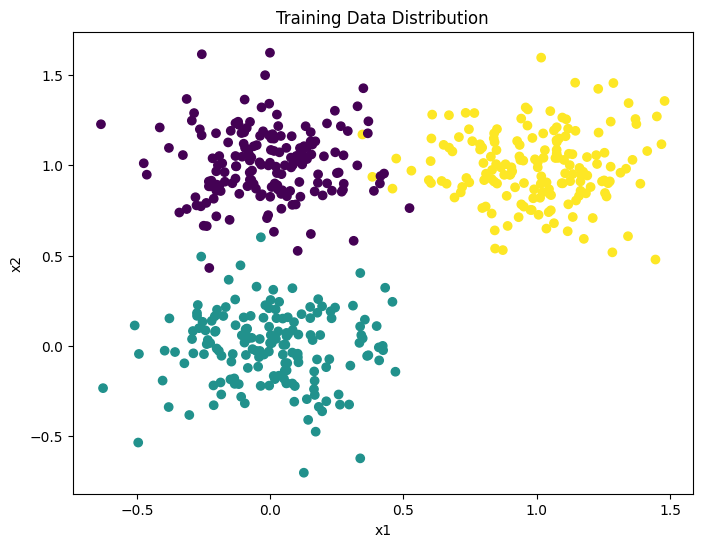

Data shape: torch.Size([500, 2])
Labels shape: torch.Size([500])


In [152]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def plot_data(X, y, title="Data Distribution"):
    """
    Plot the data points colored by their classes.
    
    Args:
        X: Input features as tensor or numpy array
        y: Labels as tensor or numpy array
        title: Plot title
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(X):
        X = X.detach().numpy()
    if torch.is_tensor(y):
        y = y.detach().numpy()
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

X, y = make_blobs(n_samples=500, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)

# Visualize the data
plot_data(X, y, title="Training Data Distribution")

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

We do the same to create test data, that will be used to compute the accuracy of our model.

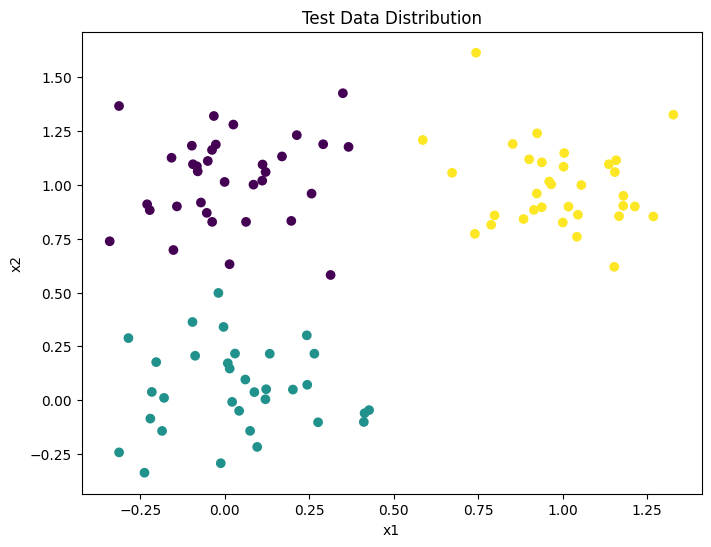

Data shape: torch.Size([100, 2])
Labels shape: torch.Size([100])


In [153]:
X_test, y_test = make_blobs(n_samples=100, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)
plot_data(X_test, y_test, title="Test Data Distribution")
# Convert to PyTorch tensors
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

print(f"Data shape: {X_test.shape}")
print(f"Labels shape: {y_test.shape}")

We also already converted those samples in torch Tensors, which are the basic and main Pytorch objects.
Observations are defined as FloatTensors, while labels are LongTensors.

We can now create a main concept in Pytorch, which is the DataLoader.
A DataLoader dispatches data in batches, ready to be used to train models.

In [154]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, y)
tr_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
print(f"Number of batches: {len(tr_dataloader)}")

Number of batches: 16


### Exercise 1
- Create 4 clusters for training and testing, using the same parameters except for the number of samples
- Plot both training and test in the same plot

## Creating a deep neural network

Once data is created, we can now develop a model that will discriminate between the three classes of the dataset.
Pytorch is increadibly flexible, since it already offers all possible operations to create networks. 
We will start by creating a simple network with only dense layers and ReLU activation functions.

In [155]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

model = Net()
print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)
Number of parameters: 371


# Train the network

We can now train our new model on the generated training data.

To do that, we need two ingredients:

* a Loss Function, which quantifies the errors of the model
* an Optimization Algorithm, to fine-tune the parameters of the model

Hence, through gradient-descent it is possible to iteratively find the optimal parameters for our simple data distribution.

Training is achieved in epochs, which stands for the amount of time the whole dataset is fed to the optimization algorithm to train the weights.

In [156]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 10, Loss: 0.0374
Epoch 20, Loss: 0.0357
Epoch 30, Loss: 0.0351
Epoch 40, Loss: 0.0348
Epoch 50, Loss: 0.0345
Epoch 60, Loss: 0.0341
Epoch 70, Loss: 0.0340
Epoch 80, Loss: 0.0334
Epoch 90, Loss: 0.0333
Epoch 100, Loss: 0.0331


We can now test our classifier, by feeding it with test data.

In [157]:
accuracy = (model(X_test).argmax(dim=1) == y_test).float().mean()
print(f"Test Accuracy: {accuracy.item()*100:.2f}%")

Test Accuracy: 100.00%


In [158]:
def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

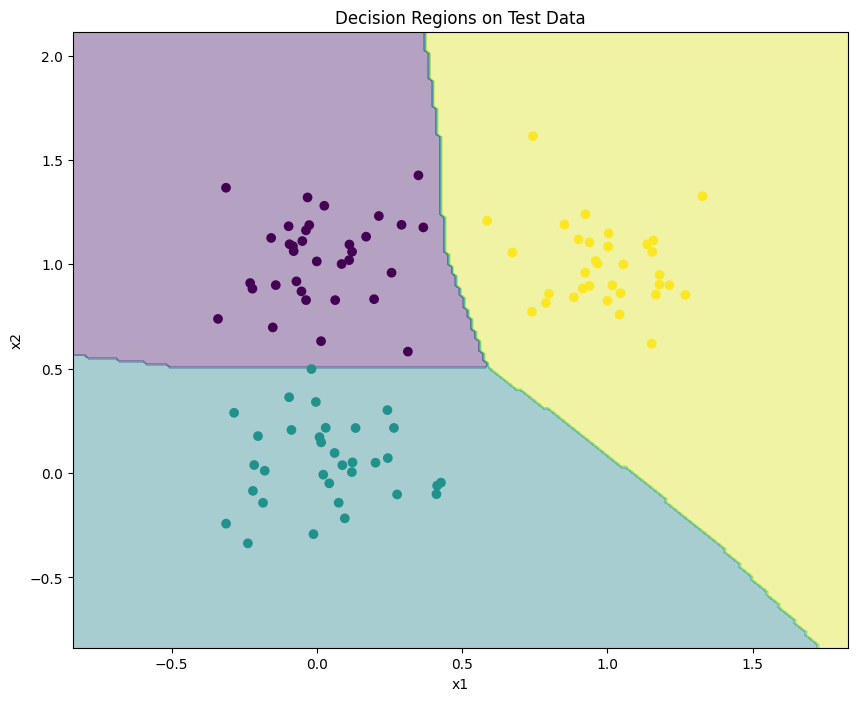

In [159]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions on Test Data")

### Exercise 2

Answer these questions:
* What happens if the number of epochs is not enough?
* What happens if the step-size of the optimizer is too little or too large?
* What happens if the number of parameters of the model are too little?

# SecML Torch

We introduce the library we will use during the course, which is [SecML Torch](https://github.com/pralab/secml-torch).
This Python library, with Pytorch at its core, can import, train and test deep neural network.

We first show how it is possible to train and test the same model with fewer lines of code.

In [160]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer

net2 = Net()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.01)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=100)
secmlt_model = BasePytorchClassifier(net2, trainer=trainer)
secmlt_model.train(tr_dataloader)

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

These three lines of code wrap the loop written before.

We can now compute the accuracy on the test. 
To do so, we can create another dataloader for the test data, since all SecML Torch works with dataloaders as input.
Also, we create an object that takes into account the accuracy score in batches.

Test accuracy: 100.00%


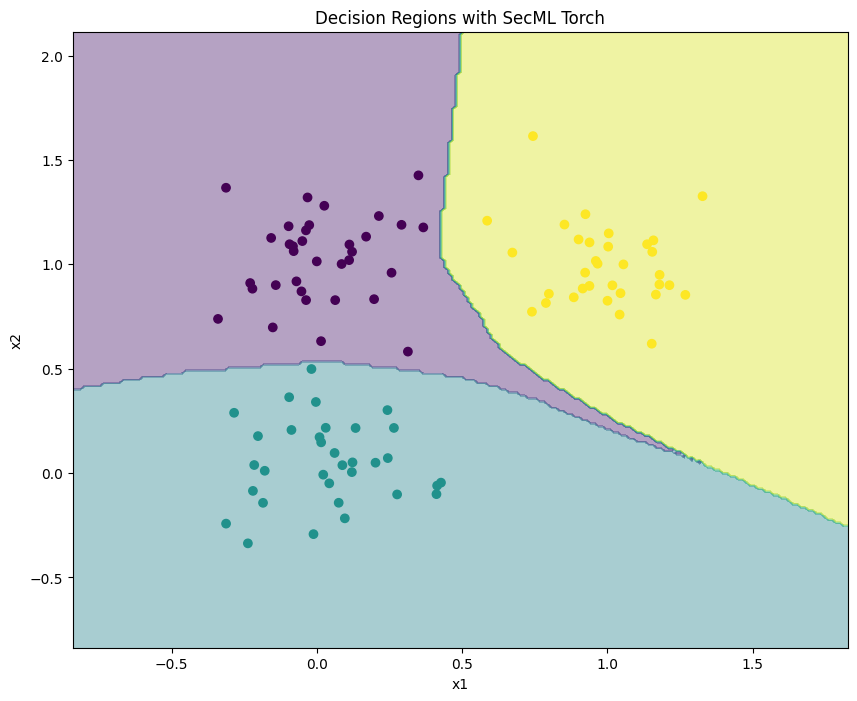

In [161]:
from secmlt.metrics.classification import Accuracy

ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

accuracy = Accuracy()(secmlt_model, ts_dataloader)

print("Test accuracy: {:.2f}%".format(accuracy * 100))

plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions with SecML Torch")

### Exercise 3

* Create a network with 4 dense layers, sigmoid activation function on each layer except for the last.
* Create the SGD optimizer, the CrossEntropy loss and the SecML Torch objects to wrap the model
* Train the model, print the accuracy and visualize the decision regions.